# libraries

In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/College/PROA Fake News - 5"
!pwd

/content/drive/MyDrive/College/PROA Fake News - 5
/content/drive/MyDrive/College/PROA Fake News - 5


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import os, re, csv, math, codecs
import string

from sklearn import metrics
from tqdm import tqdm

from keras import datasets, layers, models, optimizers, activations
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,Input,concatenate,GlobalAveragePooling1D,GlobalMaxPool1D, Activation, GRU,Conv1D
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold

# Performance metric
from sklearn.metrics import f1_score , hamming_loss, recall_score, precision_score, accuracy_score, make_scorer, classification_report
import pickle

#explanatory data analysis

In [4]:
df_fake = pd.read_csv('dataset/Fake.csv')
df_true = pd.read_csv('dataset/True.csv')

In [5]:
# checking dataset
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
# checking dataset
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
# assigning label
df_fake['label'] = 0
df_true['label'] = 1

In [8]:
# checking shape
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

In [9]:
# merging dataframe
df = pd.concat([df_fake, df_true], axis = 0)
df

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


In [10]:
# checking info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [11]:
# describe dataset
df.describe()

,label
count,44898.000000
mean,0.477015
std,0.499477
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [12]:
# checking dataset shape
df.shape

(44898, 5)

In [13]:
# checking dataset columns
df.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [14]:
# dropping any unnecessary column
df = df.drop(['title', 'subject', 'date'], axis = 1)

In [15]:
# checking is there any nan
df.isnull().sum()

text     0
label    0
dtype: int64

In [16]:
# checking duplicate dataset
df.duplicated().sum()
df = df.drop_duplicates()

In [17]:
# length of dataset
len(df)

38647

In [18]:
# reset index after delete duplicated
df = df.reset_index(drop = True)
df

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0
...,...,...
38642,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
38643,"LONDON (Reuters) - LexisNexis, a provider of l...",1
38644,MINSK (Reuters) - In the shadow of disused Sov...,1
38645,MOSCOW (Reuters) - Vatican Secretary of State ...,1


1    21192
0    17455
Name: label, dtype: int64

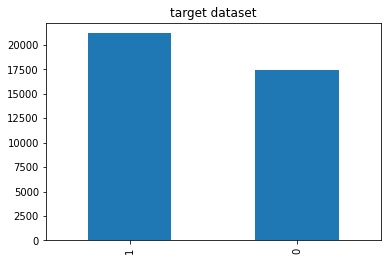

In [19]:
# visualize dataset
target = df['label'].value_counts()
target.plot(kind = 'bar', title = 'target dataset')

target

In [20]:
df

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0
...,...,...
38642,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
38643,"LONDON (Reuters) - LexisNexis, a provider of l...",1
38644,MINSK (Reuters) - In the shadow of disused Sov...,1
38645,MOSCOW (Reuters) - Vatican Secretary of State ...,1


# preprocessing

In [21]:
# preprocessing
def preprocessing(text):
    text = text.lower()
    text = re.sub('\n', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [22]:
print(preprocessing('Just when you might have thought we d get a break from watching people kiss Donald Trump s ass and stroke his ego ad nauseam, a pro-Trump group creates an ad that s nothing but people doing even more of those exact things. America First Policies is set to release this ad, called  Thank You, President Trump,  on Christmas Day and, well, we threw up a little in our mouths trying to watch this.Basically, the spot is nothing but people fawning all over Trump for all the stuff he hasn t actually done. The ad includes a scene with a little girl thanking Trump for bringing back  Merry Christmas,  which never went away (there are even videos of President Obama saying  Merry Christmas  himself). A man thanks him for cutting his taxes. And America First says that everyday Americans everywhere are thanking Trump for being such a great and awesome president.The best president.Nobody s ever done what he s done. He s breaking all kinds of records every day.Believe us.Anyway, the word  propaganda  comes to mind when watching this. That s what it is   literal propaganda promoting someone who shouldn t need this kind of promotion anymore. Watch this ad bullshit below:The way the MAGAs are kowtowing to Orange Hitler is both disgusting and frightening. The man has done nothing, and his policies will harm the very same Americans who are thanking him. Unfortunately, it will take an obscene amount of pain before they ll open their eyes and see they ve been duped by a con man with a bad hairdo.And his ongoing need for this kind of adoration is, at best, unbecoming of his office. This ad is vile.Featured image via Al Drago-Pool/Getty Images'))

just when you might have thought we d get a break from watching people kiss donald trump s ass and stroke his ego ad nauseam  a pro trump group creates an ad that s nothing but people doing even more of those exact things  america first policies is set to release this ad  called  thank you  president trump   on christmas day and  well  we threw up a little in our mouths trying to watch this basically  the spot is nothing but people fawning all over trump for all the stuff he hasn t actually done  the ad includes a scene with a little girl thanking trump for bringing back  merry christmas   which never went away  there are even videos of president obama saying  merry christmas  himself   a man thanks him for cutting his taxes  and america first says that everyday americans everywhere are thanking trump for being such a great and awesome president the best president nobody s ever done what he s done  he s breaking all kinds of records every day believe us anyway  the word  propaganda  co

In [23]:
df['text'] = df['text'].apply(preprocessing)

# dependent and independent variable

In [24]:
# checking dataset value
text = df['text'].values
label = df['label'].values

print('value of the label: ', label, '\n')
print('value of the text: ', text)

value of the label:  [0 0 0 ... 1 1 1] 

value of the text:  ['donald trump just couldn t wish all americans a happy new year and leave it at that  instead  he had to give a shout out to his enemies  haters and  the very dishonest fake news media   the former reality show star had just one job to do and he couldn t do it  as our country rapidly grows stronger and smarter  i want to wish all of my friends  supporters  enemies  haters  and even the very dishonest fake news media  a happy and healthy new year   president angry pants tweeted    will be a great year for america  as our country rapidly grows stronger and smarter  i want to wish all of my friends  supporters  enemies  haters  and even the very dishonest fake news media  a happy and healthy new year   will be a great year for america   donald j  trump   realdonaldtrump  december    s tweet went down about as welll as you d expect what kind of president sends a new year s greeting like this despicable  petty  infantile gibberis

# splitting dataset

In [25]:
#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

#max sequential per word in NN
maxseqlen = 512

In [26]:
X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X, padding = 'post', maxlen = maxseqlen)
y = to_categorical(label, num_classes = 2)

print("Shape of data tensor ['text']:", X.shape)
print("Shape of data tensor ['label']:", y.shape)

Shape of data tensor ['text']: (38647, 512)
Shape of data tensor ['label']: (38647, 2)


In [27]:
#determine vocab data used
vocab = len(tokenizer.word_index) + 1
vocab

105966

In [28]:
#split dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5)
print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)
print(Xval.shape, yval.shape)

(30917, 512) (30917, 2)
(3865, 512) (3865, 2)
(3865, 512) (3865, 2)


# building model

In [36]:
#architecture model
model = Sequential()
model.add(Embedding(input_dim = vocab, output_dim = 300, input_length = maxseqlen))
model.add(GRU(300, return_sequences = True))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))


opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 300)          31789800  
                                                                 
 gru_2 (GRU)                 (None, 512, 300)          541800    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               38528     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                      

In [37]:
checkpoint = ModelCheckpoint(
    'fakenewsdetection-BiGRU-v1.h5',
    monitor='val_loss',
    save_best_only=True
)
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [38]:
#training model
history = model.fit(Xtrain, ytrain,
                    batch_size = 64, epochs = 20,
                    validation_data = (Xval, yval), 
                    verbose = 1,
                    callbacks=checkpoint)

Epoch 1/20
484/484 [==============================] - 49s 71ms/step - loss: 0.0536 - accuracy: 0.9798 - val_loss: 0.0148 - val_accuracy: 0.9943
Epoch 2/20
484/484 [==============================] - 34s 70ms/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.0129 - val_accuracy: 0.9961
Epoch 3/20
484/484 [==============================] - 31s 64ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0173 - val_accuracy: 0.9940
Epoch 4/20
484/484 [==============================] - 31s 64ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0164 - val_accuracy: 0.9964
Epoch 5/20
484/484 [==============================] - 31s 64ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0214 - val_accuracy: 0.9969
Epoch 6/20
484/484 [==============================] - 31s 64ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.0213 - val_accuracy: 0.9961
Epoch 7/20
484/484 [==============================] - 31s 64ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0421 - val_accuracy:

# evaluation

In [39]:
loaded_model = load_model('fakenewsdetection-BiGRU-v1.h5')

121/121 - 2s - loss: 0.0105 - accuracy: 0.9966 - 2s/epoch - 18ms/step


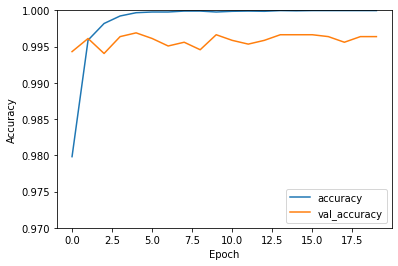

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.97, 1])
plt.legend(loc='lower right')

test_loss, test_acc = loaded_model.evaluate(Xtest,  ytest, verbose=2)

In [41]:
y_pred = loaded_model.predict(Xtest)

In [42]:
pred_class = np.where(y_pred > 0.5, 1, 0)

In [43]:
np.unique(pred_class)

array([0, 1])

In [44]:
from sklearn.metrics import classification_report

In [46]:
print(classification_report(ytest, pred_class))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1766
           1       1.00      1.00      1.00      2099

   micro avg       1.00      1.00      1.00      3865
   macro avg       1.00      1.00      1.00      3865
weighted avg       1.00      1.00      1.00      3865
 samples avg       1.00      1.00      1.00      3865

